In [1]:
import torch
print torch.__version__
import numpy as np

0.1.12


In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Read data

In [4]:
x_train = np.array(pd.read_csv('../../data/input_formated/v0/x_train.csv').iloc[:, 1:],dtype = np.float32)
y_train = np.array(pd.read_csv('../../data/input_formated/v0/y_train.csv').iloc[:, 1:],dtype = np.float32).reshape((-1, 1))
x_test = np.array(pd.read_csv('../../data/input_formated/v0/x_test.csv').iloc[:, 1:],dtype = np.float32)
y_test = np.array(pd.read_csv('../../data/input_formated/v0/y_test.csv').iloc[:, 1:],dtype = np.float32).reshape((-1, 1))

### Model

In [5]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

### Train

### ANN

In [6]:
# Neural Network Model (1 hidden layer)
class ANN_1hidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN_1hidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.activate = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_size, hidden_size)        
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn(self.activate(out))
        out = self.fc2(out)
        return self.bn2(out)

In [7]:
def train(x_data, y_data, learning_rate, num_epochs, check_point, model_save = None):
	n = int(0.8 * len(x_data))
	x_train, y_train = x_data[:n,:], y_data[:n, :]
	x_val, y_val = x_data[n:, :], y_data[n:, :]
	
	model = ANN_1hidden(x_train.shape[1], 10, y_train.shape[1])
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	train_loss_list, val_loss_list = [], []

	#early stopping
	max_patience = 100
	patience = max_patience
	best_val = None
	
	# Train the Model 
	for epoch in range(num_epochs):
		# Convert numpy array to torch Variable
		inputs = Variable(torch.from_numpy(x_train))
		targets = Variable(torch.from_numpy(y_train), requires_grad = False)

		# Forward + Backward + Optimize
		optimizer.zero_grad()  
		outputs = model(inputs)
		
		train_loss = criterion(outputs, targets).sum()
		train_loss_list.append(train_loss.data[0])
		
		#validate
		inputs = Variable(torch.from_numpy(x_val))
		targets = Variable(torch.from_numpy(y_val), requires_grad = False)
		outputs = model(inputs)   
		val_loss = criterion(outputs, targets).sum().data[0]
		val_loss_list.append(val_loss)
		
		#optimize
		train_loss.backward()
		optimizer.step()
		
		if (epoch == 0) or ((epoch+1) % check_point == 0) or (epoch == num_epochs-1):
			print ('Epoch [%d/%d], Training Loss: %.4f, Validating Loss: %.4f' 
				   %(epoch+1, num_epochs, train_loss.data[0], val_loss))
			if model_save is not None:            
				torch.save(model, '%s/%d.pth' % (model_save, epoch+1))

		if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
			best_val = val_loss
			patience =max_patience
		else:
			patience -= 1
		if patience == 0:
			print 'Early stopping at %d' % epoch
			break
		

	# Plot the graph
	print 'Plot graph from epoch 10th'
	plt.plot(range(len(train_loss_list))[10:], train_loss_list[10:], label='train')
	plt.plot(range(len(train_loss_list))[10:], val_loss_list[10:], label = 'validate')
	plt.legend()
	plt.show()
	return model

Epoch [1/1000], Training Loss: 10.9802, Validating Loss: 10.8748
Epoch [100/1000], Training Loss: 5.7197, Validating Loss: 5.6382
Epoch [200/1000], Training Loss: 2.7359, Validating Loss: 2.6989
Epoch [300/1000], Training Loss: 1.2681, Validating Loss: 1.2695
Epoch [400/1000], Training Loss: 0.6539, Validating Loss: 0.6761
Epoch [500/1000], Training Loss: 0.4385, Validating Loss: 0.4750
Epoch [600/1000], Training Loss: 0.3751, Validating Loss: 0.4187
Epoch [700/1000], Training Loss: 0.3596, Validating Loss: 0.4079
Epoch [800/1000], Training Loss: 0.3562, Validating Loss: 0.4105
Early stopping at 806
Plot graph from epoch 10th


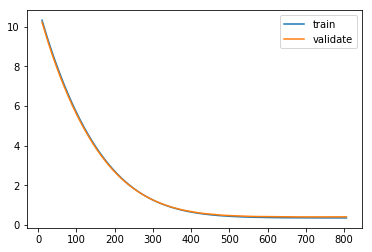

In [8]:
model = train(x_train, y_train, learning_rate = 0.01, num_epochs= 1000, check_point = 100)

# Test

In [9]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [10]:
model

ANN_1hidden (
  (fc1): Linear (18 -> 10)
  (activate): ReLU ()
  (bn): BatchNorm1d(10, eps=10, momentum=0.1, affine=True)
  (fc2): Linear (10 -> 1)
  (bn2): BatchNorm1d(1, eps=1, momentum=0.1, affine=True)
)

In [11]:
x_test = np.array(pd.read_csv('../../data/input_formated/v0/x_test.csv').iloc[:, 1:], dtype=np.float32)
y_test = np.array(pd.read_csv('../../data/input_formated/v0/y_test.csv').iloc[:, 1:], dtype=np.float32)
print x_test.shape
inputs = Variable(torch.from_numpy(x_test))
predict = model(Variable(torch.from_numpy(x_test)))
targets = Variable(torch.from_numpy(np.array(y_test, dtype=np.float32)))
rmse(predict, targets).sum()

(316, 18)


Variable containing:
 0.6376
[torch.FloatTensor of size 1]

In [12]:
x_test = np.loadtxt('../../data/input_formated/nouser/x_test.csv')
y_test = np.loadtxt('../../data/input_formated/nouser/y_test.csv')
x_test = np.array(x_test, dtype = np.float32)
y_test = np.array(y_test, dtype = np.float32)
inputs = Variable(torch.from_numpy(x_test))
predict = model(Variable(torch.from_numpy(x_test)))
targets = Variable(torch.from_numpy(np.array(y_test, dtype=np.float32)))
rmse(predict, targets).sum()

Variable containing:
 2.5334
[torch.FloatTensor of size 1]